In [1]:
%env TF_FORCE_GPU_ALLOW_GROWTH=true
import numpy as np
import pandas as pd
from keras.metrics import CategoricalAccuracy
from pandas import DataFrame
from keras.layers import TextVectorization
from sklearn.preprocessing import OneHotEncoder
import pickle
from keras.layers import Embedding, Dense, Input, GlobalMaxPooling1D, Concatenate, Bidirectional, LSTM, GlobalAveragePooling1D, AveragePooling1D
from keras import initializers
from keras.utils import plot_model
from keras import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras_tuner import HyperParameters, RandomSearch
import keras

env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
olid = pd.read_csv("../data/olid-training-v1.0.tsv", sep="\t")
olid

id                                              tweet subtask_a  \
0      86426  @USER She should ask a few native Americans wh...       OFF   
1      90194  @USER @USER Go home you’re drunk!!! @USER #MAG...       OFF   
2      16820  Amazon is investigating Chinese employees who ...       NOT   
3      62688  @USER Someone should'veTaken" this piece of sh...       OFF   
4      43605  @USER @USER Obama wanted liberals &amp; illega...       NOT   
...      ...                                                ...       ...   
13235  95338  @USER Sometimes I get strong vibes from people...       OFF   
13236  67210  Benidorm ✅  Creamfields ✅  Maga ✅   Not too sh...       NOT   
13237  82921  @USER And why report this garbage.  We don't g...       OFF   
13238  27429                                        @USER Pussy       OFF   
13239  46552  #Spanishrevenge vs. #justice #HumanRights and ...       NOT   

      subtask_b subtask_c  
0           UNT       NaN  
1           TIN       IND  
2           NaN       NaN  
3           UNT       NaN  
4           NaN       NaN  
...         ...       ...  
13235       TIN       IND  
13236       NaN       NaN  
13237       TIN       OTH  
13238       UNT       NaN  
13239       NaN       NaN  

[13240 rows x 5 columns]

In [4]:
train_data_a = olid['tweet']

lbl_train_a = olid['subtask_a']

In [5]:
train_data_b = []

lbl_train_b = []

for tweet, sb_b in zip(olid['tweet'], olid['subtask_b'].astype(str)):
    if sb_b != 'nan':
        train_data_b.append(tweet)
        lbl_train_b.append(sb_b)       

In [6]:
train_data_c = []

lbl_train_c = []

for tweet, sb_c in zip(olid['tweet'], olid['subtask_c'].astype(str)):
    if sb_c != 'nan':
        train_data_c.append(tweet)
        lbl_train_c.append(sb_c)


# construction de la couche de vectorization

In [7]:
# int pour que les tokens soient représenter par des entiers plutôt que des vecteurs
vectorizer = TextVectorization(output_sequence_length=300, output_mode="int")
vectorizer.adapt(olid['tweet'],)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
vectorizer.vocabulary_size()

22418

# transformation des tweets en vecteurs d'entiers avec la méthode vectorizer

In [8]:
training_data_a = np.array(vectorizer(np.array(train_data_a)))
training_data_b = np.array(vectorizer(np.array(train_data_b)))
training_data_c = np.array(vectorizer(np.array(train_data_c)))

In [9]:
cat_to_int_a = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_a']))))}
label_train_a = np.array([cat_to_int_a[row] for row in lbl_train_a])

cat_to_int_a, label_train_a[:5]

({'NOT': 0, 'OFF': 1}, array([1, 1, 0, 1, 0]))

In [10]:
cat_to_int_b = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_b'].astype(str))))) if label != 'nan'}

In [11]:
label_train_b = []
for row in lbl_train_b:
    try :
        label_train_b.append(cat_to_int_b[row])
    except KeyError:
        continue

np.array(label_train_b).shape

(4400,)

In [13]:
cat_to_int_c = {label : i for i, label in enumerate(list(sorted(set(olid['subtask_c'].astype(str))))) if label != 'nan'}

In [14]:
label_train_c = []

for row in lbl_train_c:
    try : 
        label_train_c.append(cat_to_int_c[row])
    except KeyError:
        continue
    
np.array(label_train_c).shape

(3876,)

# transformation des labels en one hot

In [16]:
ohe = OneHotEncoder()

y_train_ohe_a = ohe.fit_transform(np.array(label_train_a).reshape(-1,1)).toarray()

y_train_ohe_b = ohe.fit_transform(np.array(label_train_b).reshape(-1,1)).toarray()

y_train_ohe_c = ohe.fit_transform(np.array(label_train_c).reshape(-1,1)).toarray()


# chargement de la matrice d'embedding

In [17]:
embed_matrix = open("../data/embedding_matrix-1000.pickle", 'rb')
embed_matrix = pickle.load(embed_matrix)
embed_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.76435 ,  0.17534 ,  0.12309 , ...,  0.33769 , -0.059361,
        -0.11667 ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

# construction des modèles

In [18]:
# 1er modèle qui fera la classification de la première tâche

def build_model1(lstm_units=64,
                dense_units=64, 
                opti='adam'):
    int_sequences_input = Input(shape=(None,), dtype="int64", name="input_a")
    embedding1 = Embedding(
        input_dim=len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        output_dim=len(embed_matrix[0]), # dimension des embedding de chaque mot
        # embeddings_initializer=initializers.initializers_v2.Constant(embed_matrix),
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=False, 
        name='embed1_a')(int_sequences_input)

    int_sequences_input2 = Input(shape=(None,), dtype="int64", name="input2_a")
    embedding2 = Embedding(input_dim=vectorizer.vocabulary_size()+1, 
                            output_dim=len(embed_matrix[0]),
                            name='embed2_a')(int_sequences_input2)

    concat_embed = Concatenate(name="concat_embed_a")([embedding1, embedding2])
    lstm = Bidirectional(LSTM(lstm_units, name="bi"), name="lstm_a")(concat_embed)
    avg_pooling = GlobalAveragePooling1D(name='avg_pooling_a')(concat_embed)
    concat_feat = Concatenate(name="concat_feat_a")([lstm, avg_pooling])
    dense = Dense(dense_units, activation='relu', name="dense1_a")(concat_feat)
    preds_a = Dense(len(cat_to_int_a), activation="softmax", name="predict_task_a")(dense)

    model = Model(inputs=[int_sequences_input, int_sequences_input2], outputs=[preds_a], name='model_bi-lstm1')

    model.compile(optimizer=opti, loss="categorical_crossentropy", metrics=CategoricalAccuracy())
    
    return model

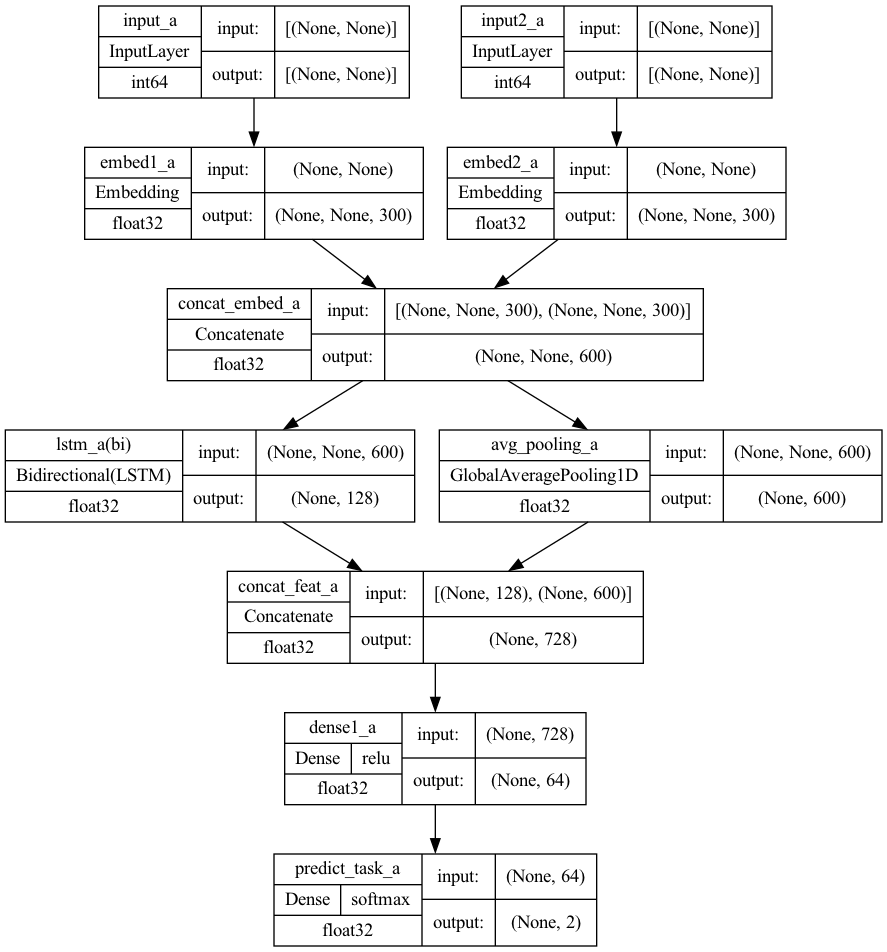

In [19]:
model1 = build_model1()
plot_model(model1, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [20]:
model1.summary()

Model: "model_bi-lstm1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_a (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_a (Embedding)        (None, None, 300)            3331620   ['input_a[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_a (Embedding)        (None, None, 300)            6725700   ['input2_a[0][0]'

In [21]:
# 2ème modèle qui fera la classification de la deuxième tâche

def build_model2(lstm_units=64,
                dense_units=64, 
                opti='adam'):
    int_sequences_input = Input(shape=(None,), dtype="int64", name="input_b")
    embedding1 = Embedding(
        input_dim=len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        output_dim=len(embed_matrix[0]), # dimension des embedding de chaque mot
        # embeddings_initializer=initializers.initializers_v2.Constant(embed_matrix),
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=False, 
        name='embed1_b')(int_sequences_input)

    int_sequences_input2 = Input(shape=(None,), dtype="int64", name="input2_b")
    embedding2 = Embedding(input_dim=vectorizer.vocabulary_size()+1, 
                            output_dim=len(embed_matrix[0]),
                            name='embed2_b')(int_sequences_input2)

    concat_embed = Concatenate(name="concat_embed_b")([embedding1, embedding2])
    lstm = Bidirectional(LSTM(lstm_units, name="bi"), name="lstm_b")(concat_embed)
    avg_pooling = GlobalAveragePooling1D(name='avg_pooling_b')(concat_embed)
    concat_feat = Concatenate(name="concat_feat_b")([lstm, avg_pooling])
    dense = Dense(dense_units, activation='relu', name="dense1_b")(concat_feat)
    preds_b = Dense(len(cat_to_int_b), activation="softmax", name="predict_task_b")(dense)

    model = Model(inputs=[int_sequences_input, int_sequences_input2], outputs=[preds_b], name='model_bi-lstm2')

    model.compile(optimizer=opti, loss="categorical_crossentropy", metrics=CategoricalAccuracy())
    
    return model

In [22]:
model2 = build_model2()
plot_model(model2, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [23]:
model2.summary()

Model: "model_bi-lstm2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_b (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_b (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_b (Embedding)        (None, None, 300)            3331620   ['input_b[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_b (Embedding)        (None, None, 300)            6725700   ['input2_b[0][0]'

In [41]:
# 3ème modèle qui fera la classification de la troisième tâche

def build_model3(lstm_units=64,
                dense_units=64, 
                opti='adam'):
    int_sequences_input = Input(shape=(None,), dtype="int64", name="input_c")
    embedding1 = Embedding(
        input_dim=len(embed_matrix), # nombre de tokens pris en charge pas la matrice
        output_dim=len(embed_matrix[0]), # dimension des embedding de chaque mot
        # embeddings_initializer=initializers.initializers_v2.Constant(embed_matrix),
        embeddings_initializer=initializers.Constant(embed_matrix),
        trainable=False, 
        name='embed1_c')(int_sequences_input)

    int_sequences_input2 = Input(shape=(None,), dtype="int64", name="input2_c")
    embedding2 = Embedding(input_dim=vectorizer.vocabulary_size()+1, 
                            output_dim=len(embed_matrix[0]),
                            name='embed2_c')(int_sequences_input2)

    concat_embed = Concatenate(name="concat_embed_c")([embedding1, embedding2])
    lstm = Bidirectional(LSTM(lstm_units, name="bi"), name="lstm_c")(concat_embed)
    avg_pooling = GlobalAveragePooling1D(name='avg_pooling_c')(concat_embed)
    concat_feat = Concatenate(name="concat_feat_c")([lstm, avg_pooling])
    dense = Dense(dense_units, activation='relu', name="dense1_c")(concat_feat)
    preds_c = Dense(len(cat_to_int_c), activation="softmax", name="predict_task_c")(dense)

    model = Model(inputs=[int_sequences_input, int_sequences_input2], outputs=[preds_c], name='model_bi-lstm3')

    model.compile(optimizer=opti, loss="categorical_crossentropy", metrics=CategoricalAccuracy())
    
    return model

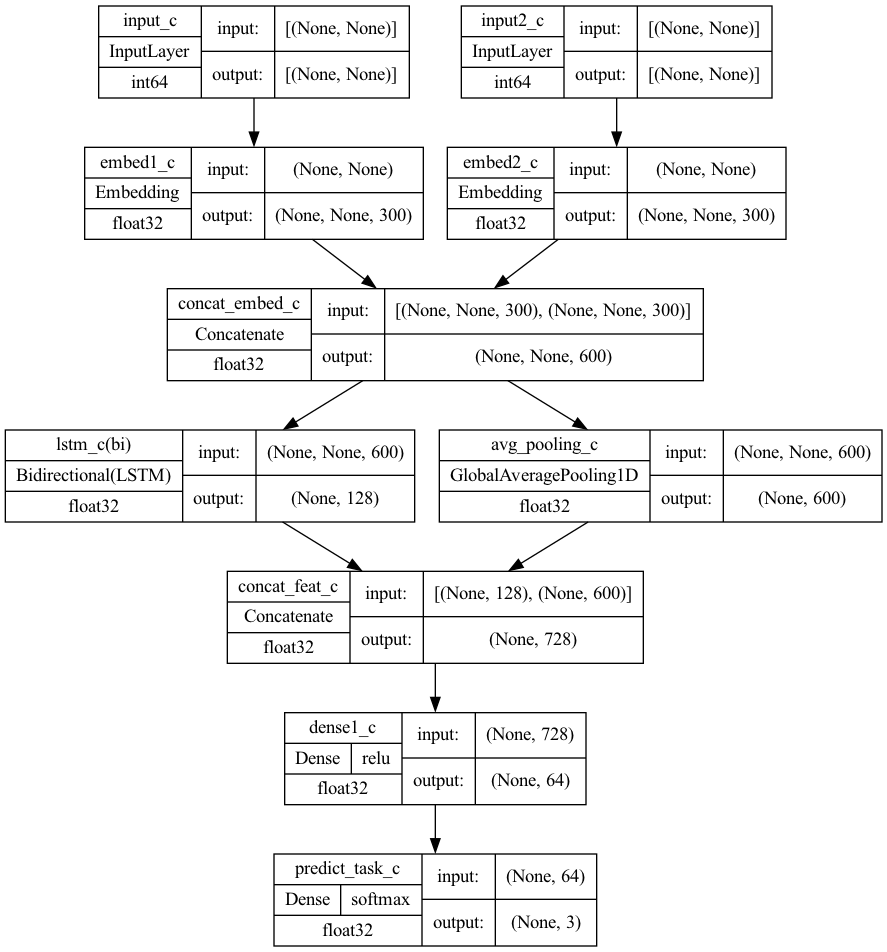

In [42]:
model3 = build_model3()
plot_model(model3, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [43]:
model3.summary()

Model: "model_bi-lstm3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_c (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_c (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_c (Embedding)        (None, None, 300)            3331620   ['input_c[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_c (Embedding)        (None, None, 300)            6725700   ['input2_c[0][0]'

In [27]:
early_val_loss = EarlyStopping("val_loss", verbose=1)
early_val_acc_a = EarlyStopping("val_categorical_accuracy", verbose=1)
early_val_acc_b = EarlyStopping("val_categorical_accuracy", verbose=1)
early_val_acc_c = EarlyStopping("val_categorical_accuracy", verbose=1)

## entrainement du modèle A

In [28]:
model1.fit(x=[training_data_a, training_data_a], y=y_train_ohe_a, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_a])

Epoch 1/100
166/166 [==============================] - 88s 520ms/step - loss: 0.5828 - categorical_accuracy: 0.7003 - val_loss: 0.5016 - val_categorical_accuracy: 0.7674
Epoch 2/100
166/166 [==============================] - 82s 491ms/step - loss: 0.3891 - categorical_accuracy: 0.8304 - val_loss: 0.5473 - val_categorical_accuracy: 0.7693
Epoch 2: early stopping


## évaluation du modèle A

In [29]:
test_olid_a = pd.read_csv("../data/testset-levela.tsv", sep="\t")
test_data_a = np.array(vectorizer(np.array(test_olid_a["tweet"])))
len(test_data_a)

860

In [30]:
res_test_a = model1.predict([test_data_a, test_data_a])

27/27 [==============================] - 3s 83ms/step


In [31]:
best_a = np.argmax(res_test_a, axis=1)
refs_a = pd.read_csv("../data/labels-levela.csv", header=None)

target = cat_to_int_a.keys()
print(classification_report(refs_a[1].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

              precision    recall  f1-score   support

         NOT       0.84      0.89      0.87       620
         OFF       0.67      0.57      0.62       240

    accuracy                           0.80       860
   macro avg       0.76      0.73      0.74       860
weighted avg       0.79      0.80      0.80       860



## entrainement du modèle B 

In [32]:
model2.fit(x=[training_data_b, training_data_b], y=y_train_ohe_b, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_b])

Epoch 1/100
55/55 [==============================] - 28s 490ms/step - loss: 0.3869 - categorical_accuracy: 0.8679 - val_loss: 0.3649 - val_categorical_accuracy: 0.8830
Epoch 2/100
55/55 [==============================] - 26s 465ms/step - loss: 0.3393 - categorical_accuracy: 0.8841 - val_loss: 0.3364 - val_categorical_accuracy: 0.8773
Epoch 2: early stopping


## évaluation du modèle B

In [33]:
test_olid_b = pd.read_csv("../data/testset-levelb.tsv", sep="\t")
test_data_b = np.array(vectorizer(np.array(test_olid_b["tweet"])))
len(test_data_b)

240

In [34]:
res_test_b = model2.predict([test_data_b, test_data_b])

8/8 [==============================] - 1s 71ms/step


In [35]:
best_b = np.argmax(res_test_b, axis=1)
refs_b = pd.read_csv("../data/labels-levelb.csv", header=None)

target = cat_to_int_b.keys()
print(classification_report(refs_b[1].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

              precision    recall  f1-score   support

         TIN       0.90      0.98      0.94       213
         UNT       0.50      0.19      0.27        27

    accuracy                           0.89       240
   macro avg       0.70      0.58      0.60       240
weighted avg       0.86      0.89      0.86       240



## entrainement du modèle C

In [40]:
training_data_c.shape, y_train_ohe_c.shape

((3876, 300), (3876, 3))

In [44]:
model3.fit(x=[training_data_c, training_data_c], y=y_train_ohe_c, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_c])

Epoch 1/100
49/49 [==============================] - 23s 443ms/step - loss: 0.8664 - categorical_accuracy: 0.6300 - val_loss: 0.7744 - val_categorical_accuracy: 0.6611
Epoch 2/100
49/49 [==============================] - 22s 440ms/step - loss: 0.6759 - categorical_accuracy: 0.7342 - val_loss: 0.7686 - val_categorical_accuracy: 0.6804
Epoch 3/100
49/49 [==============================] - 22s 442ms/step - loss: 0.5145 - categorical_accuracy: 0.8081 - val_loss: 0.9624 - val_categorical_accuracy: 0.6817
Epoch 3: early stopping


In [45]:
test_olid_c = pd.read_csv("../data/testset-levelc.tsv", sep="\t")
test_data_c = np.array(vectorizer(np.array(test_olid_c["tweet"])))
len(test_data_c)

213

In [46]:
res_test_c = model3.predict([test_data_c, test_data_c])

7/7 [==============================] - 1s 93ms/step


In [47]:
best_c = np.argmax(res_test_c, axis=1)
refs_c = pd.read_csv("../data/labels-levelc.csv", header=None)

target = cat_to_int_c.keys()
print(classification_report(refs_c[1].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

              precision    recall  f1-score   support

         GRP       0.67      0.53      0.59        78
         IND       0.60      0.91      0.72       100
         OTH       0.00      0.00      0.00        35

    accuracy                           0.62       213
   macro avg       0.42      0.48      0.44       213
weighted avg       0.53      0.62      0.56       213



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## tuning du modèle 1

In [48]:
def hypermodel1(hp: HyperParameters) -> keras.Model:
    """
    tuning du modèle 1
    """
    lstm_units = hp.Choice("lstm_unit",
                        values=[32, 64, 128, 256])
    
    dense_units = hp.Choice('dense_unit',
                        values=[32, 64, 128, 256])
    
    return build_model1(lstm_units=lstm_units, dense_units=dense_units)

In [49]:
tuner1 = RandomSearch(
    hypermodel=hypermodel1,
    objective="categorical_accuracy",
    max_trials=5,
    project_name="bi-lstm_tuning-1"
)

In [50]:
tuner1.search(x=[training_data_a, training_data_a], 
                y=y_train_ohe_a, 
                epochs=10, 
                batch_size=64, 
                validation_split=0.2)

Trial 5 Complete [00h 40m 30s]
categorical_accuracy: 0.9929192066192627

Best categorical_accuracy So Far: 0.9941465258598328
Total elapsed time: 01h 59m 24s
INFO:tensorflow:Oracle triggered exit


In [51]:
best_model1 = tuner1.get_best_models(1)[0]

In [52]:
plot_model(best_model1, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [53]:
best_model1.summary()

Model: "model_bi-lstm1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_a (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_a (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_a (Embedding)        (None, None, 300)            3331620   ['input_a[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_a (Embedding)        (None, None, 300)            6725700   ['input2_a[0][0]'

## entrainement best model 1 

In [54]:
best_model1.fit(x=[training_data_a, training_data_a], y=y_train_ohe_a, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_a])

Epoch 1/100
166/166 [==============================] - 58s 343ms/step - loss: 0.0140 - categorical_accuracy: 0.9944 - val_loss: 1.8779 - val_categorical_accuracy: 0.7277
Epoch 2/100
166/166 [==============================] - 57s 344ms/step - loss: 0.0104 - categorical_accuracy: 0.9965 - val_loss: 1.8814 - val_categorical_accuracy: 0.7281
Epoch 2: early stopping


## évaluation best model 1

In [55]:
test_olid_a = pd.read_csv("../data/testset-levela.tsv", sep="\t")
test_data_a = np.array(vectorizer(np.array(test_olid_a["tweet"])))
res_test_a = best_model1.predict([test_data_a, test_data_a])
best_a = np.argmax(res_test_a, axis=1)
refs_a = pd.read_csv("../data/labels-levela.csv", header=None)

target = cat_to_int_a.keys()
print(classification_report(refs_a[1].map(lambda x: (cat_to_int_a[x])), best_a, target_names=target))

27/27 [==============================] - 2s 48ms/step
              precision    recall  f1-score   support

         NOT       0.81      0.85      0.83       620
         OFF       0.55      0.48      0.51       240

    accuracy                           0.75       860
   macro avg       0.68      0.66      0.67       860
weighted avg       0.74      0.75      0.74       860



## tuning modèle B

In [56]:
def hypermodel2(hp: HyperParameters) -> keras.Model:
    """
    tuning du modèle 2
    """
    lstm_units = hp.Choice("lstm_unit",
                        values=[32, 64, 128, 256])
    
    dense_units = hp.Choice('dense_unit',
                        values=[32, 64, 128, 256])
    
    return build_model2(lstm_units=lstm_units, dense_units=dense_units)

In [57]:
tuner2 = RandomSearch(
    hypermodel=hypermodel2,
    objective="categorical_accuracy",
    max_trials=5,
    project_name="bi-lstm_tuning-2"
)

In [61]:
tuner2.search(x=[training_data_b, training_data_b], 
                y=y_train_ohe_b, 
                epochs=10, 
                batch_size=64, 
                validation_split=0.2)

INFO:tensorflow:Oracle triggered exit


In [62]:
best_model2 = tuner2.get_best_models(1)[0]

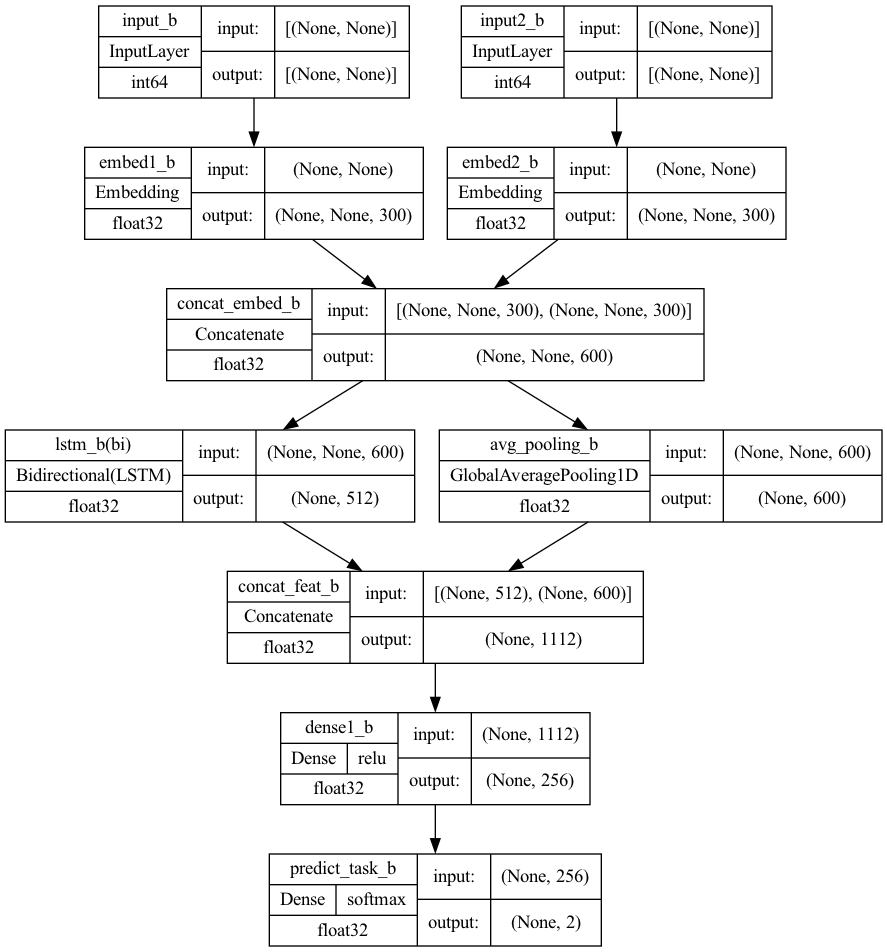

In [63]:
plot_model(best_model2, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [64]:
best_model2.summary()

Model: "model_bi-lstm2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_b (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_b (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_b (Embedding)        (None, None, 300)            3331620   ['input_b[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_b (Embedding)        (None, None, 300)            6725700   ['input2_b[0][0]'

## entrainement best model 2

In [65]:
best_model2.fit(x=[training_data_b, training_data_b], y=y_train_ohe_b, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_b])

Epoch 1/100
55/55 [==============================] - 65s 1s/step - loss: 0.0073 - categorical_accuracy: 0.9972 - val_loss: 1.2772 - val_categorical_accuracy: 0.8295
Epoch 2/100
55/55 [==============================] - 70s 1s/step - loss: 0.0065 - categorical_accuracy: 0.9963 - val_loss: 1.3247 - val_categorical_accuracy: 0.8386
Epoch 2: early stopping


## évaluation best model 2

In [66]:
test_olid_b = pd.read_csv("../data/testset-levelb.tsv", sep="\t")
test_data_b = np.array(vectorizer(np.array(test_olid_b["tweet"])))
res_test_b = best_model2.predict([test_data_b, test_data_b])
best_b = np.argmax(res_test_b, axis=1)
refs_b = pd.read_csv("../data/labels-levelb.csv", header=None)

target = cat_to_int_b.keys()
print(classification_report(refs_b[1].map(lambda x: (cat_to_int_b[x])), best_b, target_names=target))

8/8 [==============================] - 2s 206ms/step
              precision    recall  f1-score   support

         TIN       0.90      0.94      0.92       213
         UNT       0.32      0.22      0.26        27

    accuracy                           0.86       240
   macro avg       0.61      0.58      0.59       240
weighted avg       0.84      0.86      0.85       240



## tuning modèle C

In [71]:
def hypermodel3(hp: HyperParameters) -> keras.Model:
    """
    tuning du modèle 3
    """
    lstm_units = hp.Choice("lstm_unit",
                        values=[32, 64, 128, 256])
    
    dense_units = hp.Choice('dense_unit',
                        values=[32, 64, 128, 256])
    
    return build_model3(lstm_units=lstm_units, dense_units=dense_units)

In [72]:
tuner3 = RandomSearch(
    hypermodel=hypermodel3,
    objective="categorical_accuracy",
    max_trials=5,
    project_name="bi-lstm_tuning-3"
)

INFO:tensorflow:Reloading Tuner from ./bi-lstm_tuning-3/tuner0.json


In [73]:
tuner3.search(x=[training_data_c, training_data_c], 
                y=y_train_ohe_c, 
                epochs=10, 
                batch_size=64, 
                validation_split=0.2)


Trial 5 Complete [00h 04m 54s]
categorical_accuracy: 0.9916129112243652

Best categorical_accuracy So Far: 0.9964516162872314
Total elapsed time: 00h 22m 05s
INFO:tensorflow:Oracle triggered exit


In [74]:
best_model3 = tuner3.get_best_models(1)[0]

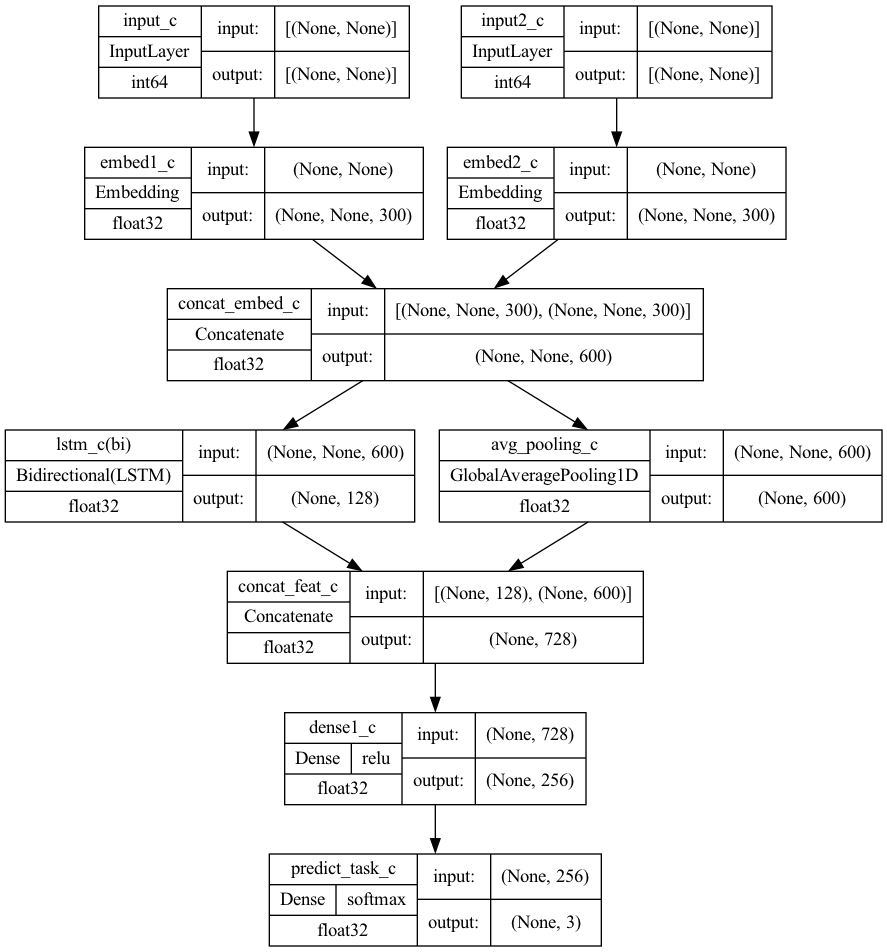

In [75]:
plot_model(best_model3, show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [76]:
best_model3.summary()

Model: "model_bi-lstm3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_c (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input2_c (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embed1_c (Embedding)        (None, None, 300)            3331620   ['input_c[0][0]']             
                                                          0                                       
                                                                                                  
 embed2_c (Embedding)        (None, None, 300)            6725700   ['input2_c[0][0]'

## entrainement best model 3

In [77]:
best_model3.fit(x=[training_data_c, training_data_c], y=y_train_ohe_c, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_val_loss, early_val_acc_c])

Epoch 1/100
49/49 [==============================] - 23s 449ms/step - loss: 0.0057 - categorical_accuracy: 0.9984 - val_loss: 3.3167 - val_categorical_accuracy: 0.5490
Epoch 2/100
49/49 [==============================] - 22s 458ms/step - loss: 0.0023 - categorical_accuracy: 0.9997 - val_loss: 3.4769 - val_categorical_accuracy: 0.5515
Epoch 2: early stopping


## évaluation best model 3

In [78]:
test_olid_c = pd.read_csv("../data/testset-levelc.tsv", sep="\t")
test_data_c = np.array(vectorizer(np.array(test_olid_c["tweet"])))
res_test_c = best_model3.predict([test_data_c, test_data_c])
best_c = np.argmax(res_test_c, axis=1)
refs_c = pd.read_csv("../data/labels-levelc.csv", header=None)

target = cat_to_int_c.keys()
print(classification_report(refs_c[1].map(lambda x: (cat_to_int_c[x])), best_c, target_names=target))

7/7 [==============================] - 1s 75ms/step
              precision    recall  f1-score   support

         GRP       0.62      0.44      0.51        78
         IND       0.70      0.72      0.71       100
         OTH       0.24      0.37      0.29        35

    accuracy                           0.56       213
   macro avg       0.52      0.51      0.50       213
weighted avg       0.59      0.56      0.57       213

